In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt
import os
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_prediction
from sahi.predict import get_sliced_prediction
import re

# from data.CityStreet.projection_code.camera_proj_Zhang import * # Projection code for image2world
from src.camera_proj_modified import *  # Projection code for image2world

In [2]:
# display list of images with image channel handling
def display_image(*imgs):
    n = len(imgs)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        if len(imgs[i].shape) == 2:  # grayscale
            plt.imshow(imgs[i], cmap='gray')
        else:  # color
            plt.imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

import math
import matplotlib.pyplot as plt
import cv2 as cv

def draw_predictions_multi(
    images,              # list of images
    predictions_list,    # list of prediction lists, same length as images
    category=None,       # optional filter (string)
    titles=None,         # list of titles, same length as images
    cols=2,              # number of columns in the grid
    figsize_per_image=(6, 6)
):
    n = len(images)
    assert len(predictions_list) == n, "predictions_list must match images length"

    if titles is None:
        titles = [f"Image {i+1}" for i in range(n)]

    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols,
                             figsize=(figsize_per_image[0]*cols,
                                      figsize_per_image[1]*rows))
    axes = axes.flatten() if rows * cols > 1 else [axes]

    for ax, img, preds, title in zip(axes, images, predictions_list, titles):
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        ax.set_title(title, fontsize=12)
        ax.axis('off')

        for pred in preds:
            # filter category
            if category is not None and pred.category.name != category:
                continue

            x1, y1, x2, y2 = map(int, pred.bbox.to_xyxy())
            ax.add_patch(plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                fill=False, edgecolor='red', linewidth=1
            ))
            ax.text(
                x1, y1 - 5,
                f'{pred.category.name}: {pred.score.value:.2f}',
                color='red', fontsize=6, weight='bold'
            )

    # turn off any unused axes
    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



In [3]:
def load_CityStreet_images(num_images, image_frames='data/CityStreet/image_frames', start_frame=636):
    camera_names = ['camera1', 'camera3', 'camera4']

    images = pd.DataFrame(columns=['frame'] + camera_names)
    for idx in range(num_images):
        frame = 2 * idx + start_frame  # camera captures every other frame
        row = {'frame': frame}
        for camera in camera_names:
            image_path = os.path.join(image_frames, camera, f'frame_{frame:04d}.jpg')
            row[camera] = cv.imread(image_path)

        images = pd.concat([images, pd.DataFrame([row])], ignore_index=True)

    return images

image_df = load_CityStreet_images(5)
image_df


,frame,camera1,camera3,camera4
0,636,"[[[28, 47, 52], [28, 47, 52], [30, 46, 52], [3...","[[[74, 94, 129], [72, 92, 127], [71, 91, 126],...","[[[158, 167, 164], [155, 164, 161], [159, 168,..."
1,638,"[[[30, 42, 48], [29, 41, 47], [29, 41, 47], [3...","[[[74, 93, 128], [74, 93, 128], [73, 93, 128],...","[[[162, 171, 168], [163, 172, 169], [164, 173,..."
2,640,"[[[29, 48, 53], [28, 47, 52], [27, 46, 51], [2...","[[[73, 94, 132], [71, 92, 130], [71, 92, 130],...","[[[157, 175, 168], [154, 172, 165], [156, 174,..."
3,642,"[[[35, 47, 53], [35, 47, 53], [33, 45, 51], [3...","[[[72, 92, 133], [71, 91, 132], [70, 90, 131],...","[[[158, 169, 167], [158, 169, 167], [159, 170,..."
4,644,"[[[34, 46, 52], [33, 45, 51], [32, 44, 50], [3...","[[[71, 91, 126], [73, 93, 128], [70, 90, 125],...","[[[154, 171, 168], [154, 171, 168], [159, 173,..."


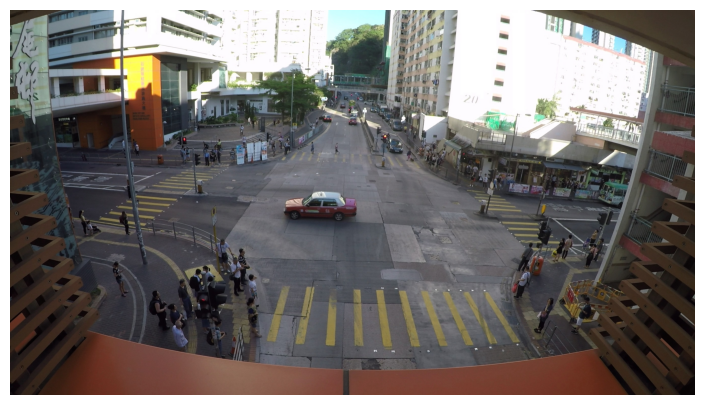

In [4]:
display_image(image_df['camera1'][1])

In [5]:
# Load a model (will auto-download on first run)
model_path = "yolo-models/yolo11s.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cpu"
)

In [6]:
img1 = image_df['camera1'][1]
img2 = image_df['camera3'][1]

In [7]:
view1_result = get_sliced_prediction(
    image=img1,
    detection_model=detection_model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)
view1_pred = view1_result.object_prediction_list

view2_result = get_sliced_prediction(
    image=img2,
    detection_model=detection_model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)
view2_pred = view2_result.object_prediction_list

Performing prediction on 28 slices.
Performing prediction on 28 slices.


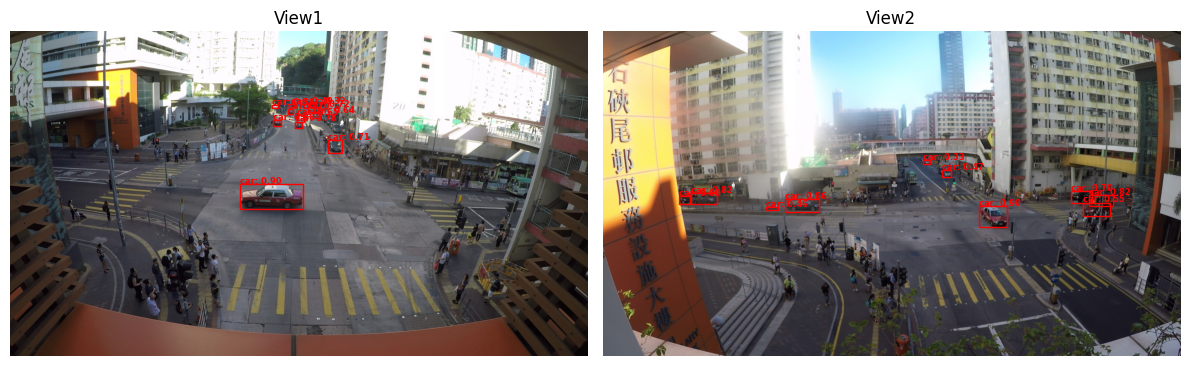

In [8]:
draw_predictions_multi(
    images=[img1, img2],
    predictions_list=[view1_pred, view2_pred],
    category='car',
    titles = ['View1', 'View2']
)

In [9]:
view1_pred[0].bbox.to_xyxy()

[np.float64(402.5815734863281),
 np.float64(988.7255859375),
 np.float64(469.3636360168457),
 np.float64(1132.9638061523438)]

In [11]:
bbox1 = view1_pred[0].bbox.to_xyxy()
x1C = (bbox1[0] + bbox1[2]) / 2
y1C = (bbox1[1] + bbox1[3]) / 2
bbox2 = view2_pred[0].bbox.to_xyxy()
x2C = (bbox2[0] + bbox2[2]) / 2
y2C = (bbox2[1] + bbox2[3]) / 2

# height = 1.65  # average car height in meters
height = find_height(x1C, y1C, x2C, y2C)
print(f"Estimated height: {height:.2f} meters")

print(Image2World("view1", x1C, y1C, height))
print(Image2World("view2", x2C, y2C, height))

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# turn bounding boxes to world coordinates Image2World('view1', Xi, Yi, Zi)  

def world_coordinates_from_bboxes(pred, view):
    pass


bounding_data = [(pred.bbox.to_xyxy(), pred.score.value, pred.category.name) for pred in predictions]  



NameError: name 'predictions' is not defined

In [104]:
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)